In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers, Sequential
import matplotlib.pyplot as plt

for g in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

print(tf.config.list_physical_devices())

np.random.seed(42)
tf.random.set_seed(42)

2025-09-30 15:20:14.503726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 15:20:15.111518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 15:20:17.363903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import kagglehub 

path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

/home/talha/miniconda3/envs/homl2wsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/talha/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/3


In [3]:
import os
AUTOTUNE = tf.data.AUTOTUNE

classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

class_names = tf.constant(classes)
class_ids = tf.range(len(classes), dtype=tf.int32)    
label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(class_names, class_ids),
    default_value=-1
)

I0000 00:00:1759234823.126082    1244 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
def parse_image_label(filepath, lookup_table):
    """Will take filepath as input preprocesses, and returns images with assigned labels"""
    label = tf.strings.split(filepath, os.sep)[-2]
    label = lookup_table.lookup(label)
    
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes)[...,0]
    image = tf.image.resize(image[..., tf.newaxis], [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.tile(image, [1, 1, 3])

    return image, label


data_augmentation = Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
            layers.RandomTranslation(0.05, 0.05),
            layers.RandomContrast(0.1)
        ])

def augment_data(image, label):
            image_batched = tf.expand_dims(image, 0) # batch_dimension
            augmented_image = data_augmentation(image_batched, training=True)
            augmented_image = tf.squeeze(augmented_image, 0)
            return augmented_image, label

In [179]:
def create_dataset(path, classes, lookup_table=label_table, batch_size=32, augment_data=False, fp_given=False):
    """Creates a dataset from given path and classes without any shuffling."""
    filepaths = []
    if fp_given != True:
        for class_ in classes:
            pattern = os.path.join(path, class_, "*.[jJ][pP][gG]") # jpg
            filepaths.extend(tf.io.gfile.glob(pattern))
            pattern = os.path.join(path, class_, "*.[jJ][pP][eE][gG]") # jpeg
            filepaths.extend(tf.io.gfile.glob(pattern))
            pattern = os.path.join(path, class_, "*.[pP][nN][gG]") # png
            filepaths.extend(tf.io.gfile.glob(pattern))
        filepaths = sorted(filepaths) 
    else:
        filepaths = path # respects order of fps, if they are given in the beginning
    
    filepaths_list = tf.data.Dataset.from_tensor_slices(filepaths)
    dataset = filepaths_list.map(lambda x : parse_image_label(x, lookup_table), num_parallel_calls=AUTOTUNE)

    if augment_data:
        augmented_ds = dataset.map(augment_data, num_parallel_calls=AUTOTUNE)
        dataset = dataset.concatenate(augmented_ds)

    if batch_size is not None:
        dataset = dataset.batch(batch_size)

    return dataset.prefetch(AUTOTUNE), filepaths

### 5 Examples from Training File Path with Augmented Data
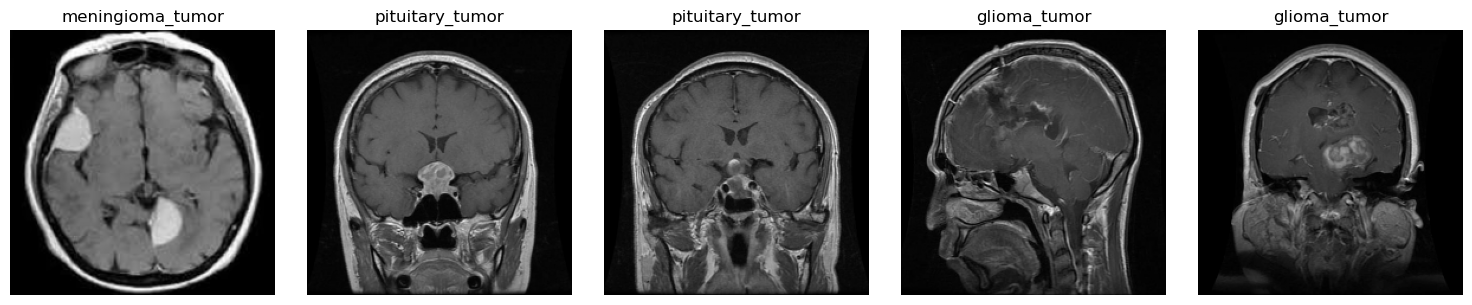

## Check Whether There is Data Leakage Between Sets

Get an auxiliery dataset of MRI scans to pretrain a CNN. This model will be used as:
1. Embedder for original dataset to check for data leakage.
2. As a patchifyer for CNN-ViT hybrid model to classify our cleaned, original dataset.

In [6]:
train_set, train_filepaths= create_dataset(train_path, classes)
test_set, test_filepaths = create_dataset(test_path, classes)

In [7]:
aux_ds_path = kagglehub.dataset_download("arwabasal/brain-tumor-mri-detection")
aux_classes = ["no", "yes"]

print("Path to dataset files:", aux_ds_path)

Path to dataset files: /home/talha/.cache/kagglehub/datasets/arwabasal/brain-tumor-mri-detection/versions/1


In [8]:
aux_classes_names = tf.constant(aux_classes)
aux_class_ids = tf.range(len(aux_classes), dtype=tf.int32)    
aux_label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(aux_classes_names, aux_class_ids),
    default_value=-1
)

In [9]:
aux_ds, aux_fp = create_dataset(aux_ds_path, aux_classes,
                                batch_size=None, lookup_table=aux_label_table)
X_aux, y_aux = [], []
for im, l in aux_ds.as_numpy_iterator():
    X_aux.append(im)
    y_aux.append(l)

X_aux = np.array(X_aux)
y_aux = np.array(y_aux)

2025-09-30 15:20:25.898078: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
base_model = Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2),       
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.Dropout(0.3),         
    layers.MaxPooling2D(2),
    layers.Conv2D(256, 3, padding="same", activation="relu"),
])


aux_clf = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),  # Small dense layer
    layers.Dense(1, activation='sigmoid')
])

# Use Adam with lower learning rate
aux_clf.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy", 
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.AUC(curve='PR', name='pr_auc')]
)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

shuffle_split = StratifiedShuffleSplit(test_size=0.2, random_state=42)
for train_idx, test_idx in shuffle_split.split(X_aux, y_aux):
    X_aux_train, X_aux_test = X_aux[train_idx], X_aux[test_idx]
    y_aux_train, y_aux_test = y_aux[train_idx], y_aux[test_idx]

print(np.unique_counts(y_aux_train), np.unique_counts(y_aux_test))

class_weights = compute_class_weight('balanced', classes=np.unique(y_aux_train), y=y_aux_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

UniqueCountsResult(values=array([0, 1], dtype=int32), counts=array([ 78, 124])) UniqueCountsResult(values=array([0, 1], dtype=int32), counts=array([20, 31]))


In [12]:
print(f"X_aux shape: {X_aux.shape}, Memory: {X_aux.nbytes / 1e6:.1f} MB")
print(f"Number of parameters in model: {aux_clf.count_params():,}")

X_aux_train, y_aux_train = tf.cast(X_aux_train, tf.float32), tf.cast(y_aux_train, tf.float32)
X_aux_test, y_aux_test = tf.cast(X_aux_test, tf.float32), tf.cast(y_aux_test, tf.float32)

X_aux shape: (253, 224, 224, 3), Memory: 152.3 MB
Number of parameters in model: 379,329


In [13]:
aux_ds = tf.data.Dataset.from_tensor_slices((X_aux_train, y_aux_train))
aux_test_ds = tf.data.Dataset.from_tensor_slices((X_aux_test, y_aux_test)).shuffle(1000).batch(64).prefetch(AUTOTUNE)
aux_augmented = aux_ds.map(augment_data, num_parallel_calls=AUTOTUNE)
aux_ds = aux_ds.concatenate(aux_augmented).shuffle(1000).batch(64).prefetch(AUTOTUNE)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(min_delta=1e-2, patience=10, factor=0.5)
early_stop = EarlyStopping(min_delta=1e-3, patience=20)
checkpoint = ModelCheckpoint("pretraining_model.keras", save_best_only=True)

aux_clf.fit(aux_ds, validation_data=aux_test_ds, class_weight=class_weight_dict,
            epochs=200, callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/200


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 897ms/step - accuracy: 0.6312 - auc: 0.6404 - loss: 0.6702 - pr_auc: 0.7075 - val_accuracy: 0.6078 - val_auc: 0.7694 - val_loss: 0.6844 - val_pr_auc: 0.7763 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6287 - auc: 0.7363 - loss: 0.6185 - pr_auc: 0.8009 - val_accuracy: 0.6078 - val_auc: 0.7903 - val_loss: 0.6749 - val_pr_auc: 0.7822 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6906 - auc: 0.7433 - loss: 0.6070 - pr_auc: 0.7958 - val_accuracy: 0.6078 - val_auc: 0.8145 - val_loss: 0.6716 - val_pr_auc: 0.7939 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6337 - auc: 0.7407 - loss: 0.6094 - pr_auc: 0.8003 - val_accuracy: 0.6078 - val_auc: 0.8089 - val_loss: 0.6705 - val_pr_auc: 0.7967 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6658 - auc: 0.7393 - loss: 0.6079 - pr_auc: 0.7839

In [15]:
aux_clf_best = keras.models.load_model("pretraining_model.keras")
aux_clf_best.evaluate(aux_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step - accuracy: 0.8235 - auc: 0.9331 - loss: 0.4372 - pr_auc: 0.9569


[0.43723705410957336,
 0.8235294222831726,
 0.9330645203590393,
 0.956882119178772]

In [16]:
def plot_images(items, test_filepaths, train_filepaths=None):
    """
    items: either
      • list/ndarray of (test_idx, train_idx) tuples  → shows side-by-side columns
      • list/ndarray of single indices or file-paths  → shows one column
    test_filepaths, train_filepaths: lists of file paths
    """
    arr = np.array(items, dtype=object)

    # CASE 1: you passed pairs of indices
    if arr.ndim == 2 and arr.shape[1] == 2:
        n = arr.shape[0]
        fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
        if n == 1:
            axes = axes[np.newaxis, :]
        for i, (ti, tr) in enumerate(arr):
            tpath = test_filepaths[ti] if isinstance(ti, (int, np.integer)) else ti
            xpath = train_filepaths[tr] if isinstance(tr, (int, np.integer)) else tr

            axes[i,0].imshow(plt.imread(tpath)); axes[i,0].set_title(f"Test idx {ti}"); axes[i,0].axis('off')
            axes[i,1].imshow(plt.imread(xpath)); axes[i,1].set_title(f"Train idx {tr}"); axes[i,1].axis('off')

    # CASE 2: you passed a 1-D list of indices or file-paths
    else:
        # determine filepaths source
        paths = train_filepaths if train_filepaths and len(items)==len(train_filepaths) else test_filepaths
        n = len(arr)
        fig, axes = plt.subplots(n, 1, figsize=(4, 3*n))
        axes = np.atleast_1d(axes)
        for i, it in enumerate(arr):
            p = paths[it] if isinstance(it, (int, np.integer)) else it
            axes[i].imshow(plt.imread(p)); axes[i].set_title(f"Idx {it}"); axes[i].axis('off')

    plt.tight_layout()
    plt.show()

There are duplicates even among test set so I will merge train and test sets, drop duplicates and split dataset to train and test again.

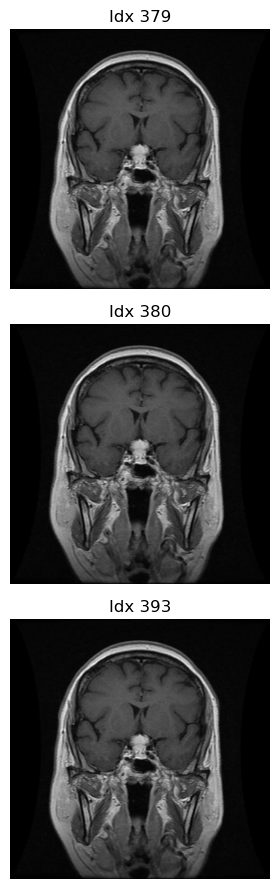

In [17]:
plot_images([379,380,393], test_filepaths)

In [18]:
embedder_base = aux_clf_best.layers[0]
embedder_model = Sequential([
    embedder_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, use_bias=False),
    layers.ReLU(),      
    layers.Dense(256, use_bias=False),
    layers.ReLU(), 
    layers.LayerNormalization(),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name="l2norm")
], name="embedder_model")
embedder_base.trainable = False

train_set_emb = embedder_model.predict(train_set)
test_set_emb = embedder_model.predict(test_set)

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [77]:
def calculate_sim_matrix(A, B, sim_pct=None, transpose_a=False, transpose_b=True):
    """Calculates a similarity matrix for given matrices, returns matrix and similarity pairs above the sim_pct"""
    similarity_matrix = tf.matmul(A, B, transpose_a=transpose_a, transpose_b=transpose_b)
    sim = similarity_matrix.numpy()
    if sim_pct != None or sim_pct != 0:
        pairs_idx= np.argwhere(sim >= sim_pct)
        pairs_idx = pairs_idx[pairs_idx[:, 0] != pairs_idx[:, 1]]
        pairs_idx = np.sort(pairs_idx, 1)
        pairs_idx = np.unique(pairs_idx, axis=0)
    else:
        pairs_idx = np.nan
    return sim, pairs_idx

In [20]:
ds = train_set.concatenate(test_set)
ds_filepaths = train_filepaths + test_filepaths
ds

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
ds_embeddings = embedder_model.predict(ds)
print(ds_embeddings.shape)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(3264, 256)


In [22]:
sim, pairs = calculate_sim_matrix(ds_embeddings, ds_embeddings, 0.999)
pairs # suspicious pairs

array([[   0,  418],
       [   0,  465],
       [   0,  517],
       ...,
       [3257, 3261],
       [3258, 3259],
       [3260, 3261]], shape=(10326, 2))

Embeddings might be similar but if they have different labels, we are sure they are different without HDBSCAN

In [23]:
pair_labels = []
same_pairs = []
for i, j in pairs:
    labels = []
    first, second = ds_filepaths[i], ds_filepaths[j]
    first = tf.cast(str.split(first, os.sep)[-2], tf.string)
    second = tf.cast(str.split(second, os.sep)[-2], tf.string)
    labels.append(label_table.lookup(first).numpy())
    labels.append(label_table.lookup(second).numpy())
    pair_labels.append(labels)

pair_labels = np.array(pair_labels)
pairs = pairs[pair_labels[:, 0] == pair_labels[:, 1]] # dropping pairs that have different labels
pairs

array([[   0,  418],
       [   0,  465],
       [   0,  517],
       ...,
       [3257, 3261],
       [3258, 3259],
       [3260, 3261]], shape=(6683, 2))

In [24]:
clustered_indices = np.unique(pairs)
unique_indices = np.setdiff1d(np.arange(len(ds_filepaths)), clustered_indices)
clustered_indices.shape, unique_indices.shape

((2604,), (660,))

In [25]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(
    min_cluster_size=2,       # even pairs form clusters
    metric="cosine",       # or "cosine" if embeddings are normalized
    cluster_selection_epsilon=0.0,
)

labels = clusterer.fit_predict(ds_embeddings[clustered_indices])

In [26]:
# idx, cluster
clusters = np.stack((clustered_indices, labels), axis=1)
clusters

array([[   0,  700],
       [   1,  773],
       [   2,  769],
       ...,
       [3260,   85],
       [3261,   85],
       [3263,  553]], shape=(2604, 2))

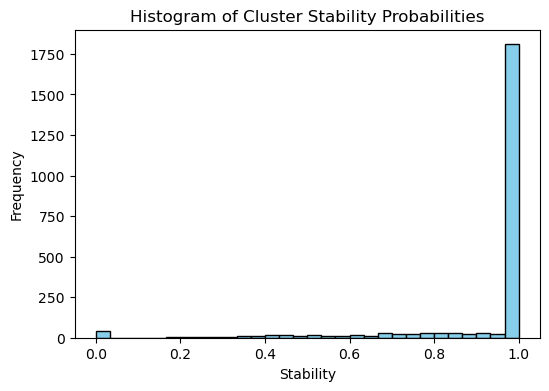

In [27]:
all_stability = clusterer.probabilities_ 
stability = clusterer.probabilities_[labels != -1] # stability array of the ones labeled as non-noise

plt.figure(figsize=(6,4))
plt.hist(stability, bins=30, color='skyblue', edgecolor='k')
plt.title("Histogram of Cluster Stability Probabilities")
plt.xlabel("Stability")
plt.ylabel("Frequency")
plt.show()

Image embeddings that model has high confidence will remain in their assigned clusters by the HDBSCAN. Considering only few of embeddings were clustered with low confidence, I will calculate a Trust Score using harmonic mean between cosine similarity and stability of HDBSCAN. High Trust scored ones will remain in their clusters, low scored ones will fall be to noisy (or unique).

Cosine similarity will be calculated according to cluster medoid.

Squared distance for square shaped matrices:
$$
∥xi​−xj​∥^2=∥xi​∥^2+∥xj​∥^2−2⟨xi​,xj​⟩
$$
full distance matrix:
$$
D^2=sq1^T+1sq^T−2G
$$

In [28]:
def get_medoid(X):
    """Calculates euclidian distances""" # (x^2 + 2xy + y^2) - 2xy
    G = X @ X.T
    sq = np.sum(X**2, axis=1, keepdims=True)
    D2 = sq + sq.T - 2*G 
    D2 = np.maximum(D2, 0) # no sqrt x < 0
    D = np.sqrt(D2)
    row_sums = D.sum(axis=1)
    medoid_idx = np.argmin(row_sums)
    return X[medoid_idx] 

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_trust_scores(cluster_embs, cluster_stabs):
    """stab_idx is idx in its cluster"""
    medoid = get_medoid(cluster_embs)
    try:
        sim_to_medoid= cosine_similarity(cluster_embs, medoid[np.newaxis, :]).ravel() # (m,1)
    except ValueError:
        print(cluster_embs.shape, medoid.shape)
    trust_scores = 2 * (sim_to_medoid * cluster_stabs) / (sim_to_medoid + cluster_stabs)
    return trust_scores

In [30]:
clusters = clusters[clusters[:, 1] != -1]
stable_clusters, suspected_clusters = (
    clusters[stability > 0.95],
    clusters[stability <= 0.95]
) # idx, cluster

In [31]:
sec_order = np.argsort(suspected_clusters[:, 0], kind='stable')
prim_order = np.argsort(suspected_clusters[sec_order, 1], kind='stable')
sorted_suspected_clusters = suspected_clusters[sec_order[prim_order]]
sorted_suspected_clusters[:5]

array([[3253,    9],
       [1714,   48],
       [1777,   57],
       [1774,  105],
       [2019,  115]])

In [52]:
per_cluster_trusts = []
for cluster in np.unique(sorted_suspected_clusters[:, 1]):
    cluster_embs_idx = clusters[clusters[:, 1] == cluster,:][:,0] # label's indices in ds_embeddings
    cluster_embs = ds_embeddings[cluster_embs_idx]
    cluster_stabs = stability[clusters[:, 1] == cluster]
    trust_scores = calculate_trust_scores(cluster_embs, cluster_stabs)
    per_cluster_trusts.append(trust_scores)

per_cluster_trusts[:5]

[array([0.04135338, 1.00000012, 0.99999988]),
 array([0.        , 1.        , 1.00000006]),
 array([1., 1., 0.]),
 array([0.03875738, 1.        , 0.99999177]),
 array([1., 1., 1., 0.])]

In [ ]:
max_len = max(arr.shape[0] for arr in per_cluster_trusts)
num_rows = len(per_cluster_trusts)
padded_trusts = np.full((num_rows, max_len), -1.0) # padding value is -1

for i, arr in enumerate(per_cluster_trusts):
    padded_trusts[i, :arr.shape[0]] = arr

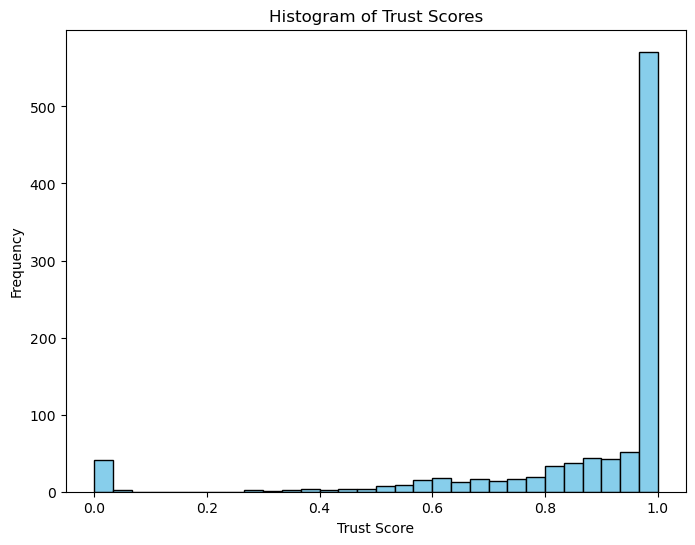

In [58]:
plt.figure(figsize=(8,6))
flattened_trusts = padded_trusts[padded_trusts != -1].ravel()
plt.hist(flattened_trusts, bins=30, color='skyblue', edgecolor='k')
plt.title("Histogram of Trust Scores")
plt.xlabel("Trust Score")
plt.ylabel("Frequency")
plt.show()

It seems most of clusterings of HDBSCAN are indeed trustworthy. The ones with high trust scores will remain in their assigned clusters (>0.92), the ones with lower trust score than 0.6 will be considered divergent, thus they will be counted as adequately unique. For the ones in the gray zone [0.6-0.92) I will apply mutual top-1 rule and leave it in cluster or remove it from the cluster accordingly.

In [ ]:
def bestmatch_to_idx(square_sim_matrix, idx):
    """It requires a square matrix, returns best matching index to the idx"""
    return np.argsort(square_sim_matrix[idx])[1]

labeled_as_unique = []
gray_zone_idx = np.argwhere(((padded_trusts < 0.92) & (padded_trusts >= 0.60)))
for i, j in gray_zone_idx: # i,j for ith label in sorted_suspected_labels, label's jth element in the clusters!!!
    label = np.unique(sorted_suspected_clusters[:, 1])[i]
    cluster_indices = clusters[clusters[:, 1] == label][:, 0] # indices in ds_embeddings
    cluster_embs = ds_embeddings[cluster_indices] # TODO: Calculate sim_matrix + mutual top-1 rule
    cluster_sim_matrix, _ = calculate_sim_matrix(cluster_embs, cluster_embs, transpose_a=True, transpose_b=False)
    best_match = bestmatch_to_idx(cluster_sim_matrix, j) # 0th element would be itself
    if bestmatch_to_idx(cluster_sim_matrix, best_match) == j:
        pass # It will remain in its cluster
    else:
        jth_in_cluster = np.take(cluster_indices, j)
        labeled_as_unique.append(jth_in_cluster) # saved to remove from its cluster later

In [72]:
labeled_as_unique = np.array(labeled_as_unique)
print(f"{gray_zone_idx.shape[0]} - {len(labeled_as_unique)}: ", gray_zone_idx.shape[0] - len(labeled_as_unique))

238 - 203:  35


In [ ]:
updated_suspected_clusters = sorted_suspected_clusters[~np.isin(sorted_suspected_clusters[:, 0], labeled_as_unique)]
final_clusters = np.vstack((stable_clusters, updated_suspected_clusters))
final_clusters # idx, cluster (unsorted)

array([[   0,  700],
       [   2,  769],
       [   3,  497],
       ...,
       [ 679,  818],
       [ 728,  818],
       [1268,  818]], shape=(2024, 2))

## Train/Test Split
Cluster sizes vary from 1-20 which means, StratfiedSampling is not good enough. To ensure both data leakage will not happen and splits are representing the whole dataset as much as possible, I will do manual splitting.

In [162]:
def train_test_split(ds_filepaths, final_clusters, lookup_table, split_ratio=0.8):
    """
    Takes filepaths of all dataset and final_clusters, assigns both unique ones and clustered ones
    to groups of their own. For each label in lookup_table given to the function, splits around split_ratio
    thus returns a list of two lists which each of this two lists contain indices of filepaths in the
    ds_filepaths.
    """
    ds_indices = np.arange(len(ds_filepaths))
    unique_indices  = np.setdiff1d(ds_indices, final_clusters[:,0])
    unique_counts = np.ones(len(unique_indices), dtype=int) # since all are unique, it will be [1,1,1...]
    unique_cluster_labels = np.unique(final_clusters[:, 1])
    cluster_counts = [] # image counts in each cluster sorted accordingly to unique_cluster_labels
    for label in unique_cluster_labels:
        count = len(np.argwhere(final_clusters[:, 1] == label))
        cluster_counts.append(count)
    max_count = max(cluster_counts)
    # size, group indices, target class(y) 3D array
    size_dim = np.concatenate((unique_counts, cluster_counts), dtype=int)

    group_idx_dim = np.full((len(size_dim), max_count), -1, dtype=int)
    start_idx_clustered = 0 # TODO: There might be a shape mismatch in here
    for i, idx in enumerate(unique_indices):
        group_idx_dim[i][0] = idx 
        start_idx_clustered = i
    start_idx_clustered = start_idx_clustered + 1
    for i, label in enumerate(unique_cluster_labels):
        group_idx = start_idx_clustered + i
        cluster_img_count = cluster_counts[i]
        group_idx_dim[group_idx, :cluster_img_count] = final_clusters[final_clusters[:, 1] == label][:, 0]

    fp_arr = np.array(ds_filepaths)
    selected_fps = fp_arr[group_idx_dim[:, 0]]
    target_classes = np.array([os.path.basename(os.path.dirname(p)) for p in selected_fps])
    target_classes = tf.constant(target_classes, dtype=tf.string) 
    target_class_ids = lookup_table.lookup(target_classes)
    target_class_dim = target_class_ids

    ds_represantation = np.hstack((size_dim[:, None], group_idx_dim, target_class_dim.numpy()[:, None]), dtype=int)
    # ds_represantation[:, 0] size, [:, 1:-1] indices, [:, -1] class label
    labels = np.arange(lookup_table.size())
    train_per_label = []
    test_per_label = []
    for label in labels:
        group_labels = ds_represantation[ds_represantation[:, -1] == label]
        sizes = np.array(group_labels[:, 0], dtype=int)
        selected_group_indices = [] # in label groups' indices in group_label
        selected_ratio = 0 
        while ((selected_ratio > split_ratio - 0.005) & (selected_ratio < split_ratio + 0.005)) == False:
            if selected_ratio >= 0.81:
                popped_idx = np.random.choice(selected_group_indices, p=sizes[selected_group_indices] / np.sum(sizes))
                selected_group_indices.pop(popped_idx)
                continue # loop continues until it reaches to the stabilazation interval
            masked_sizes = sizes.copy()
            masked_sizes[selected_group_indices] = 0
            prob_dist = masked_sizes / np.sum(masked_sizes)
            chosen_idx = np.random.choice(len(sizes), p=prob_dist)
            selected_group_indices.append(chosen_idx)
            selected_ratio = np.sum(sizes[selected_group_indices]) / np.sum(sizes) 

        train_label_img_indices = []
        for grp in selected_group_indices: 
            cnt = sizes[grp]
            train_label_img_indices.extend(group_labels[grp, 1:cnt+1])
        all_idxs = np.arange(len(sizes))
        test_label_group_indices = np.setdiff1d(all_idxs, selected_group_indices)
        test_label_img_indices = []
        for grp in test_label_group_indices:
            cnt = sizes[grp]
            test_label_img_indices.extend(group_labels[grp, 1:cnt+1])
        train_label_img_indices = np.array(train_label_img_indices, dtype=int) # label's train indices
        train_per_label.append(train_label_img_indices)
        test_label_img_indices = np.array(test_label_img_indices, dtype=int) # label's test indices
        test_per_label.append(test_label_img_indices)

    return train_per_label, test_per_label

In [164]:
splits_per_label = train_test_split(ds_filepaths, final_clusters, label_table)
trains, tests = splits_per_label
nmb = 0
for tr_lb, ts_lb in zip(trains, tests):
    print(len(tr_lb), len(ts_lb), len(tr_lb) / len(ts_lb))
    nmb = nmb + len(tr_lb) + len(ts_lb)
nmb

862 219 3.9360730593607305
652 166 3.927710843373494
402 102 3.9411764705882355
686 175 3.92


3264

In [ ]:
train_fp_indices = np.concatenate(trains).astype(int)   # create_dataset figures out label on its own
test_fp_indices  = np.concatenate(tests).astype(int)    # so concatenation and shuffling is allright
                                                        # since create_dataset doesn't do any shuffling
np.random.shuffle(train_fp_indices)
np.random.shuffle(test_fp_indices)

In [174]:
fp_arr = np.array(ds_filepaths, dtype=str)

In [183]:
train_ds = create_dataset(fp_arr[train_fp_indices], classes, label_table, fp_given=True)
test_ds = create_dataset(fp_arr[test_fp_indices], classes, label_table, fp_given=True)

## ViT Model Building, Training and Evaluation